In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
import os
import sys
import random
# custom imports
import utils
import mcts
import train
from rtfm import featurizer as X

Using device cuda:0
Using device cuda:0


In [45]:
# Create test set with optimal policy and save it

# Parameters
discount = 0.9
episode_length = 32
memory_size = 200
test_size = 200

test_rb_params = dict(
    discount = discount,
    episode_length = episode_length,
    memory_size = memory_size,
    test_size = test_size
)

# Objects
flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)
object_ids = utils.get_object_ids_dict(game_simulator)
test_rb = train.nStepsReplayBuffer(memory_size, discount)

fill = True
if fill:
    for i in range(test_size):
        results = utils.play_episode_optimal_policy_v2(game_simulator, episode_length, object_ids, reset_if_done=True)
        total_reward, frame_lst, reward_lst, done_lst, action_lst, best_action_lst = results
        test_rb.store_episode(frame_lst, reward_lst, done_lst)

/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [46]:
save = True
if save:
    num = "002"
    print("Saving test_replay_buffer number %s"%num)
    rb_dict = {
        "test_rb":test_rb,
        "test_rb_params":test_rb_params
    }
    torch.save(rb_dict, "./save_dir/test_replay_buffer_%s"%num)

Saving test_replay_buffer number 002


Out-of-distribution formula according to box plots
$$
x < Q1 - 1.5 * IQR \lor x > Q3 + 1.5 * IQR
$$

where 
- Q1 and Q3 are the first and third quartile, i.e. $P(x<Q1)=0.25$ and $P(x>Q3)=0.25$; 
- $IQR = Q3 - Q1$ is the inter-quartile range;
- outliers are points whose probability of happening would be of 0.7% or less if the distribution was Gaussian (basically outside the 2.698 $\sigma$ range, convention used in boxplots)

In [4]:
# Inner evaluation functions taking test set replay buffer, the parameters used to compute the targets
# and loaded model -> return test metrics

def test_MSE(values, targets):
    """
    Evaluates Mean Square Error (target_v - predivcted_v)^2 across all frames of all batch samples stored 
    in the test replay buffer.
    """
    loss = np.mean((values-targets)**2)
    return loss
    
def test_weighted_MSE(data, verbose=False):
    """
    data: list of n_bar numpy arrays of shape (m_i, 2), where m_i in general is different for i=0,...,n_bar-1
        First entry of the second axis contains the targets, second entry of the second axis contains the values
    
    NOTE: m_i can be 0 for some i
    
    """
    vprint = print if verbose else lambda *args, **kwargs: None
    
    vprint("len(data): ", len(data))
    group_MSEs = np.zeros(len(data)) #  store here the group MSE
    counts = np.zeros(len(data)) # store here how many points there are for each group/peak
    
    for n in range(len(data)):
        vprint("len(data[%s]): "%n, len(data[n]))
        if len(data[n]) > 0:
            t = data[n][:,0]
            v = data[n][:,1]
            counts[n] = len(data[n])
            mse = np.mean((t-v)**2)
            group_MSEs[n] = mse
        else:
            pass # 0 counts and 0 loss as a default, do not contribute to the aggregated estimate
        
    vprint("group_MSEs: ", group_MSEs)
    vprint("counts: ", counts)
    aggregated_MSE = np.sum(counts*group_MSEs/counts.sum())
    return aggregated_MSE, group_MSEs, counts
            
def test_MSE_core_distribution():
    """
    1) Groups the frames in peaks based on the target value (which tells us how many steps from the goal each 
    frame is)
    2) For each group, selects only the data falling between the first and third quartile (thus 50% of each 
    group) and computes the MSE on them 
    3) Aggregate the results weighting the various groups (up to a certain n_bar) by the number of points in 
    them (weighting using 50% of them would be identical) 
    4) Return both the aggregated result and the ones for single peaks (in case we need them for futher insights)
    """
    pass

def test_MSE_no_outliers():
    """
    Same thing of test_MSE_core_distribution, except that we keep 99.7% of the points, corresponding to points
    between Q1-1.5 IQR and Q3+1.5 IQR
    """
    pass 

def test_MSE_out_of_distribution():
    """
    Same thing of test_MSE_core_distribution, but we look only at the outliers of each group and then aggregate 
    them.
    """
    pass

In [5]:
def compute_all_test_losses(value_net, target_net, test_rb, test_rb_params, device, n_bar=10, verbose=False):
    """
    Assumptions:
    - batch_size = test_size (use all of it)
    - n_steps = episode_length (try to avoid bootstrapping as much as possible)
    """
    vprint = print if verbose else lambda *args, **kwargs: None
    target_net.eval()
    value_net.eval()
    batch_size = test_rb_params["test_size"]
    n_steps = test_rb_params["episode_length"]
    discount = test_rb_params["discount"]
    
    frames, targets = test_rb.get_batch(batch_size, n_steps, target_net, device)
    targets = targets.flatten().cpu().numpy()
    with torch.no_grad():
        values = value_net(frames).flatten().cpu().numpy()
    
    core_data, no_outliers_data, outliers_data = get_all_distributions(
        targets, values, discount, n_steps, n_bar, verbose
    )
    
    vprint("Computing standard MSE")
    test_mse = test_MSE(values, targets)
    vprint("Computing core distribution MSE aggregated by groups")
    core_mse, _, _ = test_weighted_MSE(core_data, verbose)
    vprint("Computing no outliers distribution MSE aggregated by groups")
    no_outliers_mse, _, _ = test_weighted_MSE(no_outliers_data, verbose)
    vprint("Computing outliers MSE aggregated by groups")
    outliers_mse, _, _ = test_weighted_MSE(outliers_data, verbose)
    
    return test_mse, core_mse, no_outliers_mse, outliers_mse

In [6]:
# Helper function for quartiles and groups selection
def get_target_groups(targets, values, discount, n_steps):
    # Boxplots of values grouped by targets
    V_exact =[discount**i for i in range(n_steps)][::-1]
    # Divide the pairs (target,value) based on the value of the target
    epsilon = 1e-3
    groups = []
    for i in range(n_steps):
        if i==0:
            mask_greater_than = np.ones(len(targets))
        else:
            mask_greater_than = (targets > V_exact[i-1] + epsilon) # slighly bigger than previous value

        mask_smaller_than = (targets < V_exact[i] + epsilon)
        group_mask = mask_greater_than*mask_smaller_than # logic and with boolean masks
        group_indexes = np.nonzero(group_mask)[0]
        groups.append(group_indexes)
    data = [np.concatenate([targets[indexes].reshape(-1,1), values[indexes].reshape(-1,1)], axis=1) 
            for indexes in groups]
    return data, V_exact

def get_all_distributions(targets, values, discount, n_steps, n_bar=10, verbose=False):
    vprint = print if verbose else lambda *args, **kwargs: None
    
    data, V_exact = get_target_groups(targets, values, discount, n_steps)
    
    core_data = []
    no_outliers_data = []
    outliers_data = []

    n_bar = 10 # how many peaks/targets to look at
    for n in range(1,n_bar+1):
        t = data[-n][:,0]
        v = data[-n][:,1]

        Q1, median, Q3 = np.percentile(v, q=[25,50,75])
        vprint("\nQ1:%.3f , median: %.3f, mean: %.3f, Q3: %.3f, target: %.3f, mean_trg: %.3f"%(
            Q1, median, np.mean(v), Q3, V_exact[-n], np.mean(t))
             )
        IQR = Q3-Q1

        # select "core" indexes, between Q1 and Q3
        more_than_Q1 = (v > Q1)
        less_than_Q3 = (v < Q3)
        core_mask = more_than_Q1*less_than_Q3 # logic 'and' with boolean masks
        core_indexes = np.nonzero(core_mask)[0]
        core_data_n = data[-n][core_indexes]
        vprint("len(values): ", len(v))
        vprint("len(core_indexes): ", len(core_indexes)) # ok
        vprint("core_data_n.shape. ", core_data_n.shape) # ok
        core_data.append(core_data_n)

        # select "no_outliers", betweeen Q1-1.5 IQR and Q3+1.5 IQR 
        more_than_min = (v > Q1-1.5*IQR)
        less_than_max = (v < Q3+1.5*IQR)
        no_outliers_mask = more_than_min*less_than_max # logic 'and' with boolean masks
        no_outliers_indexes = np.nonzero(no_outliers_mask)[0]
        no_outliers_data_n = data[-n][no_outliers_indexes]
        vprint("len(no_outliers_indexes): ", len(no_outliers_indexes)) # ok
        vprint("no_outliers_data_n.shape. ", no_outliers_data_n.shape) # ok
        no_outliers_data.append(no_outliers_data_n)
        
        # select "outliers" (complemetary set)
        outliers_mask = ~no_outliers_mask
        outliers_indexes = np.nonzero(outliers_mask)[0]
        vprint("len(outliers_indexes): ", len(outliers_indexes))
        if len(outliers_indexes) > 0:
            outliers_data_n = data[-n][outliers_indexes]
        else:
            outliers_data_n = np.array([])
        vprint("outliers_data_n.shape. ", outliers_data_n.shape) # ok
        outliers_data.append(outliers_data_n)
        
    return core_data, no_outliers_data, outliers_data

In [7]:
# Value-MCTS evaluation 
# both probability of solving an episode in 32 steps and average num. of episode solved
# also save episode not solved for later analysis (only in first kind of evaluation)

def evaluate_VMCTS_prob_success(ID, checkpoint, n_test_episodes=100):
    seed = 2021 
    random.seed(seed)
    np.random.seed(seed)
    
    flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
    gym_env = utils.create_env(flags)
    featurizer = X.Render()
    game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)

    training_dict = torch.load("save_dir/%s/training_dict_%s"%(ID, checkpoint))
    value_net = training_dict["value_net"]
    training_params = training_dict["training_params"]
    ucb_C = training_params["ucb_C"]
    discount = training_params["discount"]
    episode_length = training_params["episode_length"]
    max_actions = training_params["max_actions"]
    num_simulations = training_params["num_simulations"]
    device = mcts.device

    value_net.eval()
    scores = []
    problematic_episodes = []
    for i in range(n_test_episodes):
        if i == 0:
            render=True
        else:
            render=False
        results = train.play_episode_value_net(
                                        value_net,
                                        game_simulator,
                                        episode_length,
                                        ucb_C,
                                        discount,
                                        max_actions,
                                        num_simulations,
                                        mode="predict",
                                        render = render
                                        )
        total_reward, frame_lst, reward_lst, done_lst = results
        scores.append(total_reward)
        if total_reward < 1. :
            problematic_episodes.append(frame_lst)
    
    return scores, problematic_episodes

def evaluate_VMCTS_reward(ID, checkpoint, n_test_episodes=100):
    seed = 2022
    random.seed(seed)
    np.random.seed(seed)
    
    flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
    gym_env = utils.create_env(flags)
    featurizer = X.Render()
    game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)

    training_dict = torch.load("save_dir/%s/training_dict_%s"%(ID, checkpoint))
    value_net = training_dict["value_net"]
    training_params = training_dict["training_params"]
    ucb_C = training_params["ucb_C"]
    discount = training_params["discount"]
    episode_length = training_params["episode_length"]
    max_actions = training_params["max_actions"]
    num_simulations = training_params["num_simulations"]
    device = mcts.device

    value_net.eval()
    scores = []
    for i in range(n_test_episodes):
        if i == 0:
            render=True
        else:
            render=False
        results = train.play_rollout_value_net(
                                        value_net,
                                        game_simulator,
                                        episode_length,
                                        ucb_C,
                                        discount,
                                        max_actions,
                                        num_simulations,
                                        mode="predict",
                                        render = render
                                        )
        total_reward, frame_lst, reward_lst, done_lst = results
        scores.append(total_reward)
    
    return scores

In [41]:
# Outer evaluation function, looping over models/checkpoint to load (write two different functions for 
# the 2 cases) and then calling the inner evaluation function

def evaluate_checkpoints(ID, checkpoints, test_rb_num):
    # MCTS-related metrics
    prob_score = []
    reward_score = []
    trajectories_to_review = []
    
    # Value-related metrics
    test_mse_losses = []
    core_mse_losses = [] 
    no_outliers_mse_losses = []
    outliers_mse_losses = []
    
    # Test trajectories from optimal policy used to evaluate value net accuracy
    rb_dict = torch.load("./save_dir/test_replay_buffer_%s"%test_rb_num)
    test_rb = rb_dict["test_rb"]
    test_rb_params = rb_dict["test_rb_params"]
    print("Parameters used in test replay buffer %s:"%test_rb_num)
    for k in test_rb_params.keys():
        print(k, test_rb_params[k])
    
    for checkpoint in checkpoints:
        print("\nEvaluating checkpoint %s"%checkpoint)
        
        training_dict = torch.load("save_dir/%s/training_dict_%s"%(ID, checkpoint))
        value_net = training_dict["value_net"]
        target_net = training_dict["target_net"]
        results = compute_all_test_losses(value_net, target_net, test_rb, test_rb_params, mcts.device)
        test_mse, core_mse, no_outliers_mse, outliers_mse = results
        test_mse_losses.append(test_mse)
        core_mse_losses.append(core_mse)
        no_outliers_mse_losses.append(no_outliers_mse)
        outliers_mse_losses.append(outliers_mse)
        
        scores, problematic_episodes = evaluate_VMCTS_prob_success(ID, checkpoint)
        prob_score.append(np.mean(scores))
        print("Probability of solving an episode in 32 steps: %.2f"%prob_score[-1])
        trajectories_to_review.append(problematic_episodes)
        
        scores = evaluate_VMCTS_reward(ID, checkpoint)
        reward_score.append(np.mean(scores))
        print("Average number of episodes solved in 32 steps: %.2f"%reward_score[-1])
        
    evaluation_dict = dict(
        ID=ID,
        checkpoints=checkpoints,
        test_rb_num=test_rb_num,
        prob_score=prob_score,
        reward_score=reward_score,
        trajectories_to_review=trajectories_to_review,
        test_mse_losses=test_mse_losses,
        core_mse_losses=core_mse_losses,
        no_outliers_mse_losses=no_outliers_mse_losses,
        outliers_mse_losses=outliers_mse_losses
    )
    
    print("Saving result of evaluation at ./save_dir/%s/evaluation_dict"%ID)
    torch.save(evaluation_dict, "./save_dir/%s/evaluation_dict"%ID)
    return evaluation_dict
    
def evaluate_models(IDs, checkpoints, eval_number="001", n_test_episodes=100):
    # MCTS-related metrics
    prob_score = []
    reward_score = []
    trajectories_to_review = []
    
    # Value-related metrics
    test_mse_losses = []
    core_mse_losses = [] 
    no_outliers_mse_losses = []
    outliers_mse_losses = []
    
    # Test trajectories from optimal policy used to evaluate value net accuracy
    rb_dict = torch.load("./save_dir/test_replay_buffer_%s"%eval_number)
    test_rb = rb_dict["test_rb"]
    test_rb_params = rb_dict["test_rb_params"]
    print("Parameters used in test replay buffer %s:"%eval_number)
    for k in test_rb_params.keys():
        print(k, test_rb_params[k])
        
    for ID, checkpoint in zip(IDs, checkpoints):
        print("\nEvaluating ID %s at checkpoint %s"%(ID,checkpoint))
        
        training_dict = torch.load("save_dir/%s/training_dict_%s"%(ID, checkpoint))
        value_net = training_dict["value_net"]
        target_net = training_dict["target_net"]
        results = compute_all_test_losses(value_net, target_net, test_rb, test_rb_params, mcts.device)
        test_mse, core_mse, no_outliers_mse, outliers_mse = results
        test_mse_losses.append(test_mse)
        core_mse_losses.append(core_mse)
        no_outliers_mse_losses.append(no_outliers_mse)
        outliers_mse_losses.append(outliers_mse)
        
        scores, problematic_episodes = evaluate_VMCTS_prob_success(ID, checkpoint, n_test_episodes=n_test_episodes)
        prob_score.append(np.mean(scores))
        print("Probability of solving an episode in 32 steps: %.2f"%prob_score[-1])
        trajectories_to_review.append(problematic_episodes)
        
        scores = evaluate_VMCTS_reward(ID, checkpoint, n_test_episodes=n_test_episodes)
        reward_score.append(np.mean(scores))
        print("Average number of episodes solved in 32 steps: %.2f"%reward_score[-1])
        
    evaluation_dict = dict(
        IDs=IDs,
        checkpoints=checkpoints,
        eval_number=eval_number,
        prob_score=prob_score,
        reward_score=reward_score,
        trajectories_to_review=trajectories_to_review,
        test_mse_losses=test_mse_losses,
        core_mse_losses=core_mse_losses,
        no_outliers_mse_losses=no_outliers_mse_losses,
        outliers_mse_losses=outliers_mse_losses
    )
    
    print("Saving result of evaluation at ./save_dir/model_evaluation_%s"%eval_number)
    torch.save(evaluation_dict, "./save_dir/model_evaluation_%s"%eval_number)
    return evaluation_dict

# First evaluation (on different checkpoints of a single run)

In [9]:
%%time
ID = "optimal_value_AAF"
checkpoints = [i*500 for i in range(1,11)]
test_rb_num = "001"

evaluation_dict = evaluate_checkpoints(ID, checkpoints, test_rb_num)

Parameters used in test replay buffer 001:
discount 0.9
episode_length 32
memory_size 200
test_size 200
Evaluating checkpoint 500


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-04-tf2/1b2b24f2/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'my_networks.ResidualConv' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)



██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n █
█ ! @█
█    █
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ ! @█
█    █
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ ! @█
█    █
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ ! @█
█    █
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ ! @█
█    █
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ !  █
█   @█
█ ?  █
██████


██████
█y n █
█ ! @█
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?

Action  Stay : Q-value=0.559 - Visit counts=13
Action  Up : Q-value=0.633 - Visit counts=17
Action  Down : Q-value=-1.000 - Visit counts=1
Action  Left : Q-value=0.623 - Visit counts=19
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  1 (Up)

██████
█?   █
█   @█
█n   █
█  y!█
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.516 - Visit counts=13
Action  Up : Q-value=0.509 - Visit counts=17
Action  Down : Q-value=0.485 - Visit counts=16
Action  Left : Q-value=0.631 - Visit counts=20
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█?   █
█  @ █
█n   █
█  y!█
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.644 - Visit counts=16
Action  Up : Q-value=0.452 - Visit counts=9
Action  Down : Q-value=0.610 - Visit counts=16
Action  Left : Q-value=0.629 - Visit counts=14
Action  Right : Q-value=0.541 - Visit counts=14
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS

Action  Stay : Q-value=0.582 - Visit counts=21
Action  Up : Q-value=0.583 - Visit counts=21
Action  Left : Q-value=0.631 - Visit counts=27
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█?  n█
█    █
█!   █
█  @ █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.629 - Visit counts=18
Action  Up : Q-value=0.647 - Visit counts=19
Action  Left : Q-value=0.696 - Visit counts=24
Action  Right : Q-value=0.588 - Visit counts=15
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█?  n█
█    █
█!   █
█ @  █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.718 - Visit counts=17
Action  Up : Q-value=0.745 - Visit counts=19
Action  Left : Q-value=0.805 - Visit counts=24
Action  Right : Q-value=0.626 - Visit counts=13
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█?  n█
█    █
█!   █
█@   █
██████
blessed s

Action  Stay : Q-value=0.115 - Visit counts=10
Action  Up : Q-value=-1.000 - Visit counts=2
Action  Down : Q-value=0.447 - Visit counts=29
Action  Left : Q-value=0.068 - Visit counts=9
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█ n !█
█ ?  █
█   @█
█  y █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.450 - Visit counts=21
Action  Up : Q-value=0.213 - Visit counts=9
Action  Down : Q-value=0.503 - Visit counts=27
Action  Left : Q-value=0.389 - Visit counts=21
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█ n !█
█ ?  █
█    █
█  y@█
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.515 - Visit counts=26
Action  Up : Q-value=0.449 - Visit counts=20
Action  Left : Q-value=0.541 - Visit counts=30
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█ n !█
█ ?  █
█    █
█  @ █
██████
blessed sword
Reward received:  0
Done:

Action  Stay : Q-value=0.424 - Visit counts=15
Action  Up : Q-value=0.496 - Visit counts=21
Action  Down : Q-value=0.500 - Visit counts=21
Action  Left : Q-value=0.311 - Visit counts=12
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█?   █
█    █
█y!  █
█   @█
██████
gleaming sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.478 - Visit counts=28
Action  Up : Q-value=0.439 - Visit counts=23
Action  Left : Q-value=0.385 - Visit counts=19
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█?   █
█    █
█y!  █
█   @█
██████
gleaming sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.477 - Visit counts=32
Action  Up : Q-value=0.444 - Visit counts=26
Action  Left : Q-value=0.326 - Visit counts=19
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█?   █
█    █
█y!  █
█   @█
██████
gleaming sword
Reward received:  0
Done:  False
Performi

Action  Stay : Q-value=0.421 - Visit counts=21
Action  Down : Q-value=0.434 - Visit counts=19
Action  Left : Q-value=0.540 - Visit counts=32
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█n @ █
█    █
█   ?█
█   !█
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.554 - Visit counts=25
Action  Down : Q-value=0.486 - Visit counts=23
Action  Left : Q-value=0.494 - Visit counts=19
Action  Right : Q-value=0.378 - Visit counts=14
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█n @ █
█    █
█   ?█
█   !█
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.547 - Visit counts=23
Action  Down : Q-value=0.451 - Visit counts=16
Action  Left : Q-value=0.499 - Visit counts=18
Action  Right : Q-value=0.478 - Visit counts=17
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█n @ █
█    █
█   ?█
█   !█
██████
ble

Action  Stay : Q-value=0.681 - Visit counts=22
Action  Up : Q-value=0.652 - Visit counts=19
Action  Left : Q-value=0.745 - Visit counts=29
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█   n█
█    █
█ ?  █
█ !@ █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.673 - Visit counts=13
Action  Up : Q-value=0.492 - Visit counts=7
Action  Left : Q-value=1.000 - Visit counts=46
Action  Right : Q-value=0.697 - Visit counts=12
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  3 (Left)

██████
█   n█
█    █
█ ?  █
█ @  █
██████
blessed sword
Reward received:  1
Done:  True

New episode begins.

██████
█ @  █
█ ? !█
█y   █
█  n █
██████

Average number of episodes solved in 32 steps: 2.5
Evaluating checkpoint 2500

██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█

Action  Stay : Q-value=0.469 - Visit counts=21
Action  Up : Q-value=0.383 - Visit counts=19
Action  Left : Q-value=0.360 - Visit counts=17
Action  Right : Q-value=0.490 - Visit counts=23
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  4 (Right)

██████
█?   █
█    █
█y!  █
█   @█
██████
gleaming sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.440 - Visit counts=29
Action  Up : Q-value=0.432 - Visit counts=24
Action  Left : Q-value=0.388 - Visit counts=19
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█?   █
█    █
█y!  █
█   @█
██████
gleaming sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.439 - Visit counts=31
Action  Up : Q-value=0.434 - Visit counts=25
Action  Left : Q-value=0.409 - Visit counts=22
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█?   █
█    █
█y!  █
█   @█
██████
gleaming sword
Reward received:  0
Done:  False
Perfor

Action  Stay : Q-value=0.407 - Visit counts=18
Action  Down : Q-value=0.427 - Visit counts=19
Action  Left : Q-value=0.536 - Visit counts=33
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█n @ █
█    █
█   ?█
█   !█
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.555 - Visit counts=26
Action  Down : Q-value=0.432 - Visit counts=17
Action  Left : Q-value=0.498 - Visit counts=21
Action  Right : Q-value=0.479 - Visit counts=18
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█n @ █
█    █
█   ?█
█   !█
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.551 - Visit counts=21
Action  Down : Q-value=0.542 - Visit counts=20
Action  Left : Q-value=0.512 - Visit counts=18
Action  Right : Q-value=0.472 - Visit counts=16
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█n @ █
█    █
█   ?█
█   !█
██████
ble

Action  Stay : Q-value=0.457 - Visit counts=13
Action  Up : Q-value=0.411 - Visit counts=11
Action  Down : Q-value=0.450 - Visit counts=12
Action  Left : Q-value=0.517 - Visit counts=16
Action  Right : Q-value=0.392 - Visit counts=11
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█!  ?█
█    █
█@   █
█y   █
██████
gleaming sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.449 - Visit counts=14
Action  Up : Q-value=0.316 - Visit counts=9
Action  Down : Q-value=0.598 - Visit counts=27
Action  Right : Q-value=0.469 - Visit counts=15
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█!  ?█
█    █
█    █
█@   █
██████
blessed sword
Reward received:  0
Done:  False
Average number of episodes solved in 32 steps: 2.1
Evaluating checkpoint 3500

██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n █
█ ! @█
█    █
█ ?  █
██████


██████
█y n █
█ ! @█
█   

Action  Stay : Q-value=0.569 - Visit counts=17
Action  Down : Q-value=0.410 - Visit counts=10
Action  Left : Q-value=0.640 - Visit counts=23
Action  Right : Q-value=0.565 - Visit counts=18
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█@   █
█ n  █
█!   █
█?   █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.643 - Visit counts=21
Action  Down : Q-value=0.759 - Visit counts=36
Action  Right : Q-value=0.568 - Visit counts=15
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█    █
█@n  █
█!   █
█?   █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.771 - Visit counts=16
Action  Up : Q-value=0.691 - Visit counts=13
Action  Down : Q-value=1.000 - Visit counts=50
Action  Right : Q-value=0.439 - Visit counts=6
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  2 (Down)

██████
█    █
█ n  █
█@   █
█?   █
██████
bless

Action  Stay : Q-value=0.551 - Visit counts=16
Action  Up : Q-value=0.382 - Visit counts=12
Action  Down : Q-value=0.383 - Visit counts=10
Action  Left : Q-value=0.612 - Visit counts=21
Action  Right : Q-value=0.520 - Visit counts=15
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  3 (Left)

██████
█! ? █
█    █
█ @  █
█  n █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.618 - Visit counts=15
Action  Up : Q-value=0.613 - Visit counts=15
Action  Down : Q-value=0.568 - Visit counts=13
Action  Left : Q-value=0.675 - Visit counts=19
Action  Right : Q-value=0.407 - Visit counts=8
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  3 (Left)

██████
█! ? █
█    █
█@   █
█  n █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.673 - Visit counts=16
Action  Up : Q-value=0.782 - Visit counts=25
Action  Down : Q-value=0.625 - Visit counts=13
Action  Right : Q-value=0.647 


██████
█ n ?█
█  @ █
█   !█
█y   █
██████

Performing MCTS step
Action  Stay : Q-value=0.294 - Visit counts=10
Action  Up : Q-value=0.072 - Visit counts=8
Action  Down : Q-value=0.321 - Visit counts=11
Action  Left : Q-value=0.429 - Visit counts=16
Action  Right : Q-value=-0.106 - Visit counts=5
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  3 (Left)

██████
█ n ?█
█ @  █
█   !█
█y   █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.435 - Visit counts=13
Action  Up : Q-value=0.388 - Visit counts=12
Action  Down : Q-value=0.473 - Visit counts=15
Action  Left : Q-value=0.442 - Visit counts=14
Action  Right : Q-value=0.296 - Visit counts=11
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  2 (Down)

██████
█ n ?█
█    █
█ @ !█
█y   █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.470 - Visit counts=14
Action  Up : Q-value=0.426 - Visit counts=12
Action  Down : Q-value=0.507 - Visit c

Action  Stay : Q-value=0.717 - Visit counts=12
Action  Up : Q-value=0.661 - Visit counts=9
Action  Down : Q-value=1.000 - Visit counts=33
Action  Left : Q-value=0.710 - Visit counts=10
Action  Right : Q-value=0.435 - Visit counts=6
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  2 (Down)

██████
█?   █
█    █
█   n█
█  @ █
██████
blessed sword
Reward received:  1
Done:  True

New episode begins.

██████
█?  @█
█    █
█ y! █
█  n █
██████

Performing MCTS step
Action  Stay : Q-value=0.418 - Visit counts=20
Action  Down : Q-value=0.383 - Visit counts=15
Action  Left : Q-value=0.385 - Visit counts=15
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█?  @█
█    █
█ y! █
█  n █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.482 - Visit counts=28
Action  Down : Q-value=0.408 - Visit counts=20
Action  Left : Q-value=0.414 - Visit counts=21
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)


Action  Stay : Q-value=0.806 - Visit counts=17
Action  Up : Q-value=1.000 - Visit counts=43
Action  Right : Q-value=0.710 - Visit counts=13
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  1 (Up)

██████
█?  n█
█    █
█@   █
█    █
██████
blessed sword
Reward received:  1
Done:  True

New episode begins.

██████
█   y█
█ @ n█
█    █
█ ! ?█
██████

Performing MCTS step
Action  Stay : Q-value=0.387 - Visit counts=11
Action  Up : Q-value=0.398 - Visit counts=11
Action  Down : Q-value=0.177 - Visit counts=6
Action  Left : Q-value=0.351 - Visit counts=10
Action  Right : Q-value=0.425 - Visit counts=12
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  4 (Right)

██████
█   y█
█  @n█
█    █
█ ! ?█
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.428 - Visit counts=12
Action  Up : Q-value=0.445 - Visit counts=13
Action  Down : Q-value=0.303 - Visit counts=11
Action  Left : Q-value=0.385 - Visit counts=11
Action  Right : Q-value=0.4

Action  Stay : Q-value=0.513 - Visit counts=22
Action  Up : Q-value=0.439 - Visit counts=16
Action  Left : Q-value=0.394 - Visit counts=14
Action  Right : Q-value=0.411 - Visit counts=19
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█    █
█   !█
█?  n█
█  @y█
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.511 - Visit counts=24
Action  Up : Q-value=0.295 - Visit counts=12
Action  Left : Q-value=0.313 - Visit counts=15
Action  Right : Q-value=0.467 - Visit counts=20
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█    █
█   !█
█?  n█
█  @y█
██████

Reward received:  0
Done:  False
Average number of episodes solved in 32 steps: 2.1
Saving result of evaluation at ./save_dir/optimal_value_AAF/evaluation_dict
CPU times: user 3h 55min 52s, sys: 37.1 s, total: 3h 56min 30s
Wall time: 3h 56min 39s


# Second evaluation (on past models)

In [47]:
%%time
IDs = ["optimal_value_ACA",
       "optimal_value_ACB",
       "optimal_value_ACC",
       "optimal_value_ACD",
       "optimal_value_ACE",
       "optimal_value_ACF",
       "optimal_value_ACG",
       "optimal_value_ACH",
       "optimal_value_ACI",
       "optimal_value_ACL"
      ]

checkpoints = ["5000"]*len(IDs) # same checkpoint for all runs
evaluation_dict = evaluate_models(IDs, checkpoints, eval_number="002", n_test_episodes=10)

Parameters used in test replay buffer 002:
discount 0.9
episode_length 32
memory_size 200
test_size 200

Evaluating ID optimal_value_ACA at checkpoint 5000

██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y @ █
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█y@  █
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█@   █
█ !  █
█    █
█ ?  █
██████
blessed sword

██████
█    █
█@!  █
█    █
█ ?  █
██████
blessed sword

██████
█    █
█ @  █
█    █
█ ?  █
██████
blessed sword
Probability of solving an episode in 32 steps: 0.70

██████
█ n  █
█?   █
█@   █
█y ! █
██████

Performing MCTS step
Action  Stay : Q-value=0.500 - Visit counts=15
Action  Up : Q-value=-1.000 - Visit counts=1
Action  Down : Q-value=0.542 - Visit counts=21
Action  Right : Q-value=0.467 - Visit counts=13
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

█████

Action  Stay : Q-value=0.526 - Visit counts=11
Action  Up : Q-value=0.583 - Visit counts=17
Action  Down : Q-value=0.592 - Visit counts=14
Action  Left : Q-value=0.241 - Visit counts=7
Action  Right : Q-value=0.598 - Visit counts=15
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  4 (Right)

██████
█ !n █
█?   █
█  @ █
█    █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.588 - Visit counts=15
Action  Up : Q-value=0.491 - Visit counts=11
Action  Down : Q-value=0.566 - Visit counts=13
Action  Left : Q-value=0.411 - Visit counts=12
Action  Right : Q-value=0.566 - Visit counts=13
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  0 (Stay)

██████
█ !n █
█?   █
█  @ █
█    █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.613 - Visit counts=14
Action  Up : Q-value=0.487 - Visit counts=9
Action  Down : Q-value=0.569 - Visit counts=12
Action  Left : Q-value=0.660 -

Action  Stay : Q-value=0.389 - Visit counts=21
Action  Down : Q-value=0.204 - Visit counts=10
Action  Left : Q-value=0.401 - Visit counts=17
Action  Right : Q-value=0.436 - Visit counts=20
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  4 (Right)

██████
█   @█
█    █
█   ?█
█   !█
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.353 - Visit counts=16
Action  Down : Q-value=0.396 - Visit counts=19
Action  Left : Q-value=0.519 - Visit counts=34
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█  @ █
█    █
█   ?█
█   !█
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.534 - Visit counts=23
Action  Down : Q-value=0.462 - Visit counts=22
Action  Left : Q-value=0.523 - Visit counts=22
Action  Right : Q-value=0.439 - Visit counts=16
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█  @ █
█    █
█   ?█
█   !█
██████
bl

Action  Stay : Q-value=0.404 - Visit counts=30
Action  Up : Q-value=0.359 - Visit counts=28
Action  Left : Q-value=0.363 - Visit counts=25
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█ !  █
█ n?y█
█    █
█   @█
██████

Reward received:  0
Done:  False
Average number of episodes solved in 32 steps: 1.00

Evaluating ID optimal_value_ACC at checkpoint 5000

██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y @ █
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█y  @█
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█y  @█
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█y  @█
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█y  @█
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█y  @█
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█y   █
█ ! @█
█    █
█ ?  █
██████
gleaming sword

██████
█y   █
█ !  █
█   @█
█ ?  █
██████
gleaming sword

██████
█y   █
█ !  █
█   @█
█ ?  █
██████
gleaming sword

Action  Stay : Q-value=0.685 - Visit counts=14
Action  Up : Q-value=0.625 - Visit counts=11
Action  Down : Q-value=0.763 - Visit counts=18
Action  Left : Q-value=0.654 - Visit counts=13
Action  Right : Q-value=0.626 - Visit counts=11
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  2 (Down)

██████
█    █
█   n█
█ @  █
█ ! ?█
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.779 - Visit counts=11
Action  Up : Q-value=0.703 - Visit counts=9
Action  Down : Q-value=1.000 - Visit counts=27
Action  Left : Q-value=0.745 - Visit counts=10
Action  Right : Q-value=0.716 - Visit counts=10
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  2 (Down)

██████
█    █
█   n█
█    █
█ @ ?█
██████
blessed sword
Reward received:  1
Done:  True

New episode begins.

██████
█n   █
█ !  █
█@ y █
█ ?  █
██████

Performing MCTS step
Action  Stay : Q-value=0.225 - Visit counts=12
Action  Up : Q-value=0.289 - Visit counts=18
Action  Down 


██████
█ n  █
█?   █
█    █
█  @ █
██████
blessed sword
Reward received:  1
Done:  True

New episode begins.

██████
█n  y█
█    █
█@  ?█
█   !█
██████

Performing MCTS step
Action  Stay : Q-value=0.293 - Visit counts=13
Action  Up : Q-value=0.333 - Visit counts=15
Action  Down : Q-value=0.250 - Visit counts=11
Action  Right : Q-value=0.258 - Visit counts=11
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  1 (Up)

██████
█n  y█
█@   █
█   ?█
█   !█
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.330 - Visit counts=16
Action  Up : Q-value=0.373 - Visit counts=19
Action  Down : Q-value=0.288 - Visit counts=13
Action  Right : Q-value=0.333 - Visit counts=16
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  1 (Up)

██████
█@  y█
█    █
█   ?█
█   !█
██████
gleaming sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.365 - Visit counts=22
Action  Down : Q-value=0.365 - Visit counts=22
Action  R

Action  Stay : Q-value=0.338 - Visit counts=11
Action  Up : Q-value=0.495 - Visit counts=20
Action  Left : Q-value=0.280 - Visit counts=10
Action  Right : Q-value=0.562 - Visit counts=27
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  4 (Right)

██████
█ !  █
█   n█
█?   █
█  @ █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.566 - Visit counts=22
Action  Up : Q-value=0.533 - Visit counts=19
Action  Left : Q-value=0.440 - Visit counts=17
Action  Right : Q-value=0.524 - Visit counts=18
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█ !  █
█   n█
█?   █
█  @ █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.570 - Visit counts=23
Action  Up : Q-value=0.521 - Visit counts=19
Action  Left : Q-value=0.306 - Visit counts=9
Action  Right : Q-value=0.530 - Visit counts=20
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

███

Action  Stay : Q-value=0.592 - Visit counts=9
Action  Up : Q-value=0.652 - Visit counts=11
Action  Down : Q-value=1.000 - Visit counts=47
Action  Left : Q-value=0.721 - Visit counts=13
Action  Right : Q-value=-1.000 - Visit counts=1
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  2 (Down)

██████
█  n █
█  ? █
█ @  █
█    █
██████
blessed sword
Reward received:  1
Done:  True

New episode begins.

██████
█n! y█
█@   █
█  ? █
█    █
██████

Performing MCTS step
Action  Stay : Q-value=0.408 - Visit counts=15
Action  Up : Q-value=0.172 - Visit counts=8
Action  Down : Q-value=0.465 - Visit counts=19
Action  Right : Q-value=0.203 - Visit counts=8
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█n! y█
█    █
█@ ? █
█    █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.393 - Visit counts=18
Action  Up : Q-value=0.333 - Visit counts=17
Action  Down : Q-value=0.446 - Visit counts=23
Action  Right : Q-value=0.22


██████
█?  @█
█    █
█y!  █
█   n█
██████

Performing MCTS step
Action  Stay : Q-value=0.486 - Visit counts=18
Action  Down : Q-value=0.503 - Visit counts=19
Action  Left : Q-value=0.415 - Visit counts=13
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█?   █
█   @█
█y!  █
█   n█
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.496 - Visit counts=20
Action  Up : Q-value=0.481 - Visit counts=18
Action  Down : Q-value=0.398 - Visit counts=13
Action  Left : Q-value=0.467 - Visit counts=17
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█?   █
█   @█
█y!  █
█   n█
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.502 - Visit counts=20
Action  Up : Q-value=0.484 - Visit counts=18
Action  Down : Q-value=0.404 - Visit counts=14
Action  Left : Q-value=0.470 - Visit counts=17
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█?   

Action  Stay : Q-value=0.482 - Visit counts=32
Action  Up : Q-value=0.432 - Visit counts=25
Action  Left : Q-value=0.415 - Visit counts=23
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█?   █
█    █
█y!  █
█   @█
██████
gleaming sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.481 - Visit counts=33
Action  Up : Q-value=0.386 - Visit counts=25
Action  Left : Q-value=0.405 - Visit counts=23
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█?   █
█    █
█y!  █
█   @█
██████
gleaming sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.398 - Visit counts=29
Action  Up : Q-value=0.422 - Visit counts=27
Action  Left : Q-value=0.420 - Visit counts=26
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  1 (Up)

██████
█?   █
█    █
█y! @█
█    █
██████
gleaming sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.424 - Visit

Action  Stay : Q-value=0.500 - Visit counts=20
Action  Up : Q-value=0.351 - Visit counts=14
Action  Down : Q-value=0.435 - Visit counts=16
Action  Left : Q-value=0.451 - Visit counts=17
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█! ? █
█    █
█   @█
█  n █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.504 - Visit counts=21
Action  Up : Q-value=0.378 - Visit counts=16
Action  Down : Q-value=0.441 - Visit counts=15
Action  Left : Q-value=0.465 - Visit counts=17
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█! ? █
█    █
█   @█
█  n █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.504 - Visit counts=19
Action  Up : Q-value=0.469 - Visit counts=16
Action  Down : Q-value=0.439 - Visit counts=14
Action  Left : Q-value=0.536 - Visit counts=21
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  3 (Left)

██████


██████
█y  @█
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█y @ █
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█y@  █
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█@   █
█ !  █
█    █
█ ?  █
██████
blessed sword

██████
█    █
█@!  █
█    █
█ ?  █
██████
blessed sword

██████
█    █
█ @  █
█    █
█ ?  █
██████
blessed sword
Probability of solving an episode in 32 steps: 0.60

██████
█ n  █
█?   █
█@   █
█y ! █
██████

Performing MCTS step
Action  Stay : Q-value=0.524 - Visit counts=15
Action  Up : Q-value=-1.000 - Visit counts=1
Action  Down : Q-value=0.615 - Visit counts=22
Action  Right : Q-value=0.454 - Visit counts=12
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█ n  █
█?   █
█    █
█@ ! █
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.609 - Visit counts=20
Action  Up : Q-value=0.306 - Visit counts=8
Action  Right : Q-value=0.771 - Visit counts=43
Tree info:  {'max_tree_depth':

Action  Stay : Q-value=0.671 - Visit counts=17
Action  Up : Q-value=0.609 - Visit counts=14
Action  Down : Q-value=0.798 - Visit counts=30
Action  Left : Q-value=0.272 - Visit counts=8
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  2 (Down)

██████
█    █
█    █
█    █
█?n!@█
██████
blessed sword
Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.801 - Visit counts=19
Action  Up : Q-value=0.705 - Visit counts=13
Action  Left : Q-value=1.000 - Visit counts=47
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  3 (Left)

██████
█    █
█    █
█    █
█?n@ █
██████
blessed sword
Reward received:  1
Done:  True

New episode begins.

██████
█?n@y█
█    █
█    █
█   !█
██████

Performing MCTS step
Action  Stay : Q-value=0.552 - Visit counts=14
Action  Down : Q-value=0.517 - Visit counts=12
Action  Left : Q-value=0.314 - Visit counts=7
Action  Right : Q-value=0.614 - Visit counts=17
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:

Action  Stay : Q-value=0.671 - Visit counts=14
Action  Up : Q-value=1.000 - Visit counts=36
Action  Down : Q-value=0.421 - Visit counts=5
Action  Left : Q-value=0.694 - Visit counts=11
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  1 (Up)

██████
█   @█
█    █
█n   █
█   ?█
██████
blessed sword
Reward received:  1
Done:  True

New episode begins.

██████
█  ?y█
█  ! █
█  @n█
█    █
██████

Performing MCTS step
Action  Stay : Q-value=0.390 - Visit counts=12
Action  Up : Q-value=-1.000 - Visit counts=2
Action  Down : Q-value=0.341 - Visit counts=11
Action  Left : Q-value=0.388 - Visit counts=12
Action  Right : Q-value=0.328 - Visit counts=13
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  0 (Stay)

██████
█  ?y█
█  ! █
█  @n█
█    █
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.173 - Visit counts=8
Action  Up : Q-value=-1.000 - Visit counts=2
Action  Down : Q-value=0.369 - Visit counts=15
Action  Left : Q-value=0.390 -

Action  Stay : Q-value=0.399 - Visit counts=19
Action  Up : Q-value=0.383 - Visit counts=18
Action  Left : Q-value=0.346 - Visit counts=15
Action  Right : Q-value=0.372 - Visit counts=17
Tree info:  {'max_tree_depth': 4}
Action selected from MCTS:  0 (Stay)

██████
█  ?y█
█  ! █
█   n█
█ @  █
██████

Reward received:  0
Done:  False
Average number of episodes solved in 32 steps: 3.10

Evaluating ID optimal_value_ACL at checkpoint 5000

██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y n@█
█ !  █
█    █
█ ?  █
██████


██████
█y @ █
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█y@  █
█ !  █
█    █
█ ?  █
██████
gleaming sword

██████
█@   █
█ !  █
█    █
█ ?  █
██████
blessed sword

██████
█ @  █
█ !  █
█    █
█ ?  █
██████
blessed sword

██████
█    █
█ @  █
█    █
█ ?  █
██████
blessed sword
Probability of solving an episode in 32 steps: 0.70

██████
█ n  █
█?   █
█@   █
█y ! █
██████

Pe

Action  Stay : Q-value=0.534 - Visit counts=19
Action  Up : Q-value=0.413 - Visit counts=12
Action  Down : Q-value=0.239 - Visit counts=9
Action  Left : Q-value=0.344 - Visit counts=11
Action  Right : Q-value=0.494 - Visit counts=17
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  0 (Stay)

██████
█?   █
█  @ █
█y!  █
█   n█
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.532 - Visit counts=20
Action  Up : Q-value=0.400 - Visit counts=12
Action  Down : Q-value=0.386 - Visit counts=11
Action  Left : Q-value=0.273 - Visit counts=8
Action  Right : Q-value=0.491 - Visit counts=17
Tree info:  {'max_tree_depth': 3}
Action selected from MCTS:  0 (Stay)

██████
█?   █
█  @ █
█y!  █
█   n█
██████

Reward received:  0
Done:  False
Performing MCTS step
Action  Stay : Q-value=0.327 - Visit counts=12
Action  Up : Q-value=0.514 - Visit counts=17
Action  Down : Q-value=0.406 - Visit counts=12
Action  Left : Q-value=0.386 - Visit counts=12
Action  Ri

# Visualization of results

In [15]:
#ID = "optimal_value_AAF"
#eval_dict = torch.load("./save_dir/%s/evaluation_dict"%ID)
eval_dict = torch.load("./save_dir/model_evaluation_001")

In [16]:
eval_dict.keys()

dict_keys(['IDs', 'checkpoints', 'eval_number', 'prob_score', 'reward_score', 'trajectories_to_review', 'test_mse_losses', 'core_mse_losses', 'no_outliers_mse_losses', 'outliers_mse_losses'])

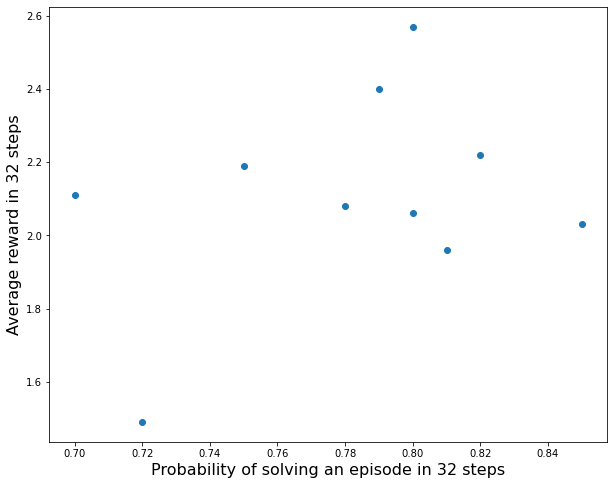

In [17]:
# Check correlation between the 2 metrics to evaluate the V-MCTS performance 
plt.figure(figsize=(10,8))
plt.scatter(eval_dict["prob_score"], eval_dict["reward_score"] )
plt.xlabel("Probability of solving an episode in 32 steps", fontsize=16)
plt.ylabel("Average reward in 32 steps", fontsize=16)
plt.show()

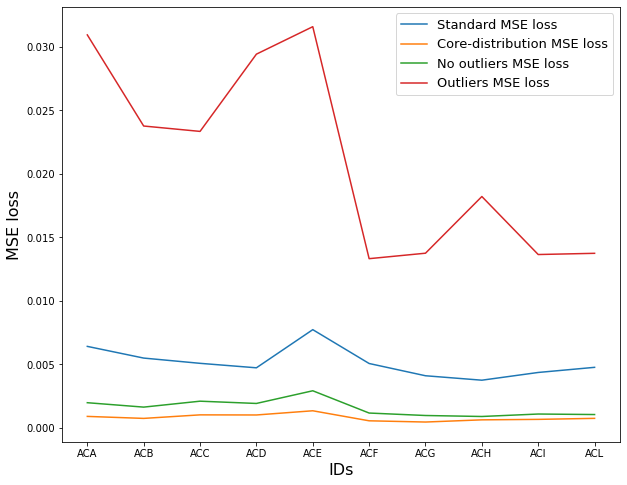

In [25]:
# Plot the 4 different MSE losses as a function of the checkpoints to see how correlated they are
# Check correlation between the 2 metrics to evaluate the V-MCTS performance 
plt.figure(figsize=(10,8))
x = np.arange(len(eval_dict["IDs"]))
plt.plot(x, eval_dict["test_mse_losses"], label="Standard MSE loss")
plt.plot(x, eval_dict["core_mse_losses"], label="Core-distribution MSE loss")
plt.plot(x, eval_dict["no_outliers_mse_losses"], label="No outliers MSE loss")
plt.plot(x, eval_dict["outliers_mse_losses"], label="Outliers MSE loss")
plt.xlabel("IDs", fontsize=16)
plt.xticks(ticks=x, labels=[ID[-3:] for ID in IDs])
plt.ylabel("MSE loss", fontsize=16)
plt.legend(fontsize=13)
plt.show()

In [20]:
# Compute correlation between each MSE loss and each score, see which is higher
# remember: correlation matrix is covariance matrix divided by the standard deviation of the 2 variables
score_keys = ["prob_score", "reward_score"]
loss_keys = ["test_mse_losses","core_mse_losses","no_outliers_mse_losses","outliers_mse_losses"]
for sk in score_keys:
    for lk in loss_keys:
        corr = np.corrcoef(eval_dict[lk], eval_dict[sk])[0,1] # diagonal term of 2x2 correlation matrix
        print("Correlation between %s and %s: %.3f"%(lk,sk,corr))

Correlation between test_mse_losses and prob_score: -0.214
Correlation between core_mse_losses and prob_score: -0.122
Correlation between no_outliers_mse_losses and prob_score: -0.186
Correlation between outliers_mse_losses and prob_score: -0.111
Correlation between test_mse_losses and reward_score: -0.765
Correlation between core_mse_losses and reward_score: -0.568
Correlation between no_outliers_mse_losses and reward_score: -0.615
Correlation between outliers_mse_losses and reward_score: -0.326


Comment: 
1. using different checkpoints from the same run is not possible to find any good indicator of performance.
2. It should also be noticed that there is no clear correlation between the 2 metrics used to evaluate the V-MCTS; maybe one should use many more test episodes, but already now just the evaluation of 20 checkpoints is taking 4 hours.
3. Using different runs there is a significant (negative) correlation between the various losses and the reward score, whereas the correlation is much less pronounced if we look at the probability score. This is probably because the latter saturates to 1, so it's much more restricted in range; also, the result does not show the optimality of the solution, because 32 steps are a lot and any solvable episode can be solved in that amount of steps even in a non-optimal way.

Text(0, 0.5, 'Value MSE loss on test set')

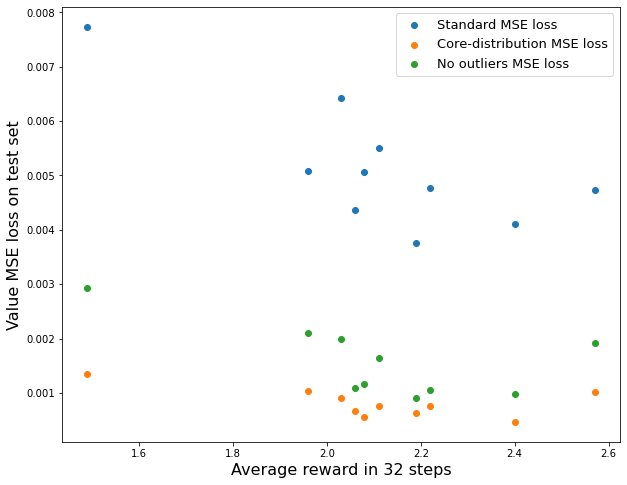

In [30]:
plt.figure(figsize=(10,8))
plt.scatter(eval_dict["reward_score"], eval_dict["test_mse_losses"], label="Standard MSE loss")
plt.scatter(eval_dict["reward_score"], eval_dict["core_mse_losses"], label="Core-distribution MSE loss")
plt.scatter(eval_dict["reward_score"], eval_dict["no_outliers_mse_losses"], label="No outliers MSE loss")
#plt.scatter(eval_dict["reward_score"], eval_dict["outliers_mse_losses"], label="Outliers MSE loss")
plt.legend(fontsize=13)
plt.xlabel("Average reward in 32 steps", fontsize=16)
plt.ylabel("Value MSE loss on test set", fontsize=16)

In [37]:
best_index = np.argmax(eval_dict["reward_score"])
best_ID = IDs[best_index]
print("Best ID: ", best_ID[-3:])
print("Parameters used in the network:")
network_params = torch.load("./save_dir/%s/network_params"%best_ID)
for k in network_params.keys():
    print(k, network_params[k])
if "support_size" not in list(network_params.keys()):
    print("Network uses standard value net (no discrete support set).")

Best ID:  ACD
Parameters used in the network:
emb_dim 10
conv_channels 256
conv_layers 2
residual_layers 6
linear_features_in 256
linear_feature_hidden 256
Network uses standard value net (no discrete support set).


# Looking at problematic trajectories

In [50]:
eval_dict = torch.load("./save_dir/model_evaluation_002")
traj_to_review = eval_dict["trajectories_to_review"]

In [60]:
def render_trajectory(traj, object_ids):
    print("Length trajectory: %d\n"%len(traj))
    for frame in traj:
        utils.render_frame(frame, object_ids)

In [58]:
len(traj_to_review[0])

3

In [61]:
for i in range(len(traj_to_review)):
    for j in range(len(traj_to_review[i])):
        print("-"*40)
        render_trajectory(traj_to_review[i][j], object_ids)

----------------------------------------
Length trajectory: 33
██████
█  ! █
█ @ n█
█   y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█  @y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█  @y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█  @y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█
██████

██████
█  ! █
█   n█
█ @ y█
█   ?█

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y@ █
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y@ █
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y @█
█ ?  █
█    █
█ !  █
██████

██████
█ y  █
█ ? @█
█    █
█ !  █
██████

██████
█ y  █
█ ?  █
█   @█
█ !  █
██████

██████
█ y  █
█ ? @█
█    █
█ !  █
██████

----------------------------------------
Length trajectory: 33
██████
█y n@█
█ !  █
█    █
█ ?  █
██████

██████
█y n@█
█ !  █
█    █
█ ?  █
██████

██████
█y n@█
█ !  █
█    █
█ ?  █
██████

██████
█y n@█
█ !  █
█    █
█ ?  █

██████
█! n █
█?   █
█ @  █
█    █
██████

██████
█! n █
█?   █
█  @ █
█    █
██████

██████
█! n █
█?   █
█  @ █
█    █
██████

██████
█! n █
█?   █
█  @ █
█    █
██████

██████
█! n █
█?   █
█ @  █
█    █
██████

██████
█! n █
█?   █
█  @ █
█    █
██████

██████
█! n █
█?   █
█ @  █
█    █
██████

██████
█! n █
█?   █
█  @ █
█    █
██████

----------------------------------------
Length trajectory: 33
██████
█y ? █
█!n  █
█@   █
█    █
██████

██████
█y ? █
█!n  █
█ @  █
█    █
██████

██████
█y ? █
█!n  █
█  @ █
█    █
██████

██████
█y ? █
█!n  █
█  @ █
█    █
██████

██████
█y ? █
█!n  █
█    █
█  @ █
██████

██████
█y ? █
█!n  █
█  @ █
█    █
██████

██████
█y ? █
█!n  █
█ @  █
█    █
██████

██████
█y ? █
█!n  █
█ @  █
█    █
██████

██████
█y ? █
█!n  █
█    █
█ @  █
██████

██████
█y ? █
█!n  █
█    █
█ @  █
██████

██████
█y ? █
█!n  █
█    █
█  @ █
██████

██████
█y ? █
█!n  █
█    █
█  @ █
██████

██████
█y ? █
█!n  █
█    █
█ @  █
██████

██████
█y ? █
█!n  █
█    █
█ @  █

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█    █
█! @y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█   @█
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█    █
█! @y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█   @█
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█   @█
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█   @█
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█    █
█   @█
█!  y█
█   ?█
██████

██████
█    █
█  @ █
█!  y█
█   ?█
██████

██████
█   

Comment: the vast majority of problems are encountered BEFORE collecting the yes (y) item. 
Since the agent gets stuck in some positions and no additional information is available, probably is better to use the analysis of optimal trajectories instead and integrate it with the informations obtained by running MCTS at each step (without playing the action).

# Dev & test snippets

In [6]:
# Init objects and variables to test inner evaluation functions
ID = "optimal_value_AAF"
checkpoint = 5000

training_dict = torch.load("save_dir/%s/training_dict_%s"%(ID, checkpoint))
value_net = training_dict["value_net"]
target_net = training_dict["target_net"]

/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-04-tf2/1b2b24f2/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'my_networks.ResidualConv' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [ ]:
# How to test MCTS on same set of episodes? -> create an environment, save its state dict -> do that X times 
# use that list of dict for all models



In [76]:
compute_all_test_losses(value_net, target_net, test_rb, test_rb_params, mcts.device, verbose=True)


Q1:0.985 , median: 0.993, mean: 0.991, Q3: 1.000, target: 1.000, mean_trg: 0.999
len(values):  1014
len(core_indexes):  506
core_data_n.shape.  (506, 2)
len(no_outliers_indexes):  985
no_outliers_data_n.shape.  (985, 2)
len(outliers_indexes):  29
outliers_data_n.shape.  (29, 2)

Q1:0.881 , median: 0.892, mean: 0.883, Q3: 0.902, target: 0.900, mean_trg: 0.898
len(values):  1041
len(core_indexes):  518
core_data_n.shape.  (518, 2)
len(no_outliers_indexes):  968
no_outliers_data_n.shape.  (968, 2)
len(outliers_indexes):  73
outliers_data_n.shape.  (73, 2)

Q1:0.782 , median: 0.799, mean: 0.783, Q3: 0.812, target: 0.810, mean_trg: 0.807
len(values):  1032
len(core_indexes):  516
core_data_n.shape.  (516, 2)
len(no_outliers_indexes):  904
no_outliers_data_n.shape.  (904, 2)
len(outliers_indexes):  128
outliers_data_n.shape.  (128, 2)

Q1:0.675 , median: 0.713, mean: 0.698, Q3: 0.732, target: 0.729, mean_trg: 0.726
len(values):  934
len(core_indexes):  466
core_data_n.shape.  (466, 2)
len(n

(0.007174236,
 0.0007752573548292594,
 0.0017951856383883152,
 0.028276647875517064)

In [46]:
batch_size = test_rb_params["test_size"]
n_steps = test_rb_params["episode_length"]
discount = test_rb_params["discount"]

frames, targets = test_rb.get_batch(batch_size, n_steps, target_net, mcts.device)
with torch.no_grad():
    values = value_net(frames).flatten().cpu().numpy()
targets = targets.flatten().cpu().numpy()

In [ ]:
# Both data and V_exact are ordered from the group with smallest value to the one with highest value
data, V_exact = get_target_groups(targets, values, discount, n_steps)

In [59]:
core_data = []
no_outliers_data = []
outliers_data = []

n_bar = 10 # how many peaks/targets to look at
for n in range(1,n_bar+1):
    targets = data[-n][:,0]
    values = data[-n][:,1]
    
    Q1, median, Q3 = np.percentile(values, q=[25,50,75])
    print("\nQ1:%.3f , median: %.3f, mean: %.3f, Q3: %.3f, target: %.3f, mean_trg: %.3f"%(
        Q1, median, np.mean(values), Q3, V_exact[-n], np.mean(values))
         )
    IQR = Q3-Q1
    
    # select "core" indexes, between Q1 and Q3
    more_than_Q1 = (values > Q1)
    less_than_Q3 = (values < Q3)
    core_mask = more_than_Q1*less_than_Q3 # logic 'and' with boolean masks
    core_indexes = np.nonzero(core_mask)[0]
    core_data_n = data[-n][core_indexes]
    print("len(values): ", len(values))
    print("len(core_indexes): ", len(core_indexes)) # ok
    print("core_data_n.shape. ", core_data_n.shape) # ok
    core_data.append(core_data_n)
    
    # select "no_outliers", betweeen Q1-1.5 IQR and Q3+1.5 IQR 
    more_than_min = (values > Q1-1.5*IQR)
    less_than_max = (values < Q3+1.5*IQR)
    no_outliers_mask = more_than_min*less_than_max # logic 'and' with boolean masks
    no_outliers_indexes = np.nonzero(no_outliers_mask)[0]
    no_outliers_data_n = data[-n][no_outliers_indexes]
    print("len(no_outliers_indexes): ", len(no_outliers_indexes)) # ok
    print("no_outliers_data_n.shape. ", no_outliers_data_n.shape) # ok
    
    # select "outliers" (complemetary set)
    outliers_mask = ~no_outliers_mask
    outliers_indexes = np.nonzero(outliers_mask)[0]
    print("len(outliers_indexes): ", len(outliers_indexes))
    if len(outliers_indexes) > 0:
        outliers_data_n = data[-n][outliers_indexes]
    else:
        outliers_data_n = np.array([])
    print("outliers_data_n.shape. ", outliers_data_n.shape) # ok
    print("len(outliers_data_n): ", len(outliers_data_n))


Q1:0.985 , median: 0.993, mean: 0.991, Q3: 1.000, target: 1.000, mean_trg: 0.991
len(values):  1014
len(core_indexes):  506
core_data_n.shape.  (506, 2)
len(no_outliers_indexes):  985
no_outliers_data_n.shape.  (985, 2)
len(outliers_indexes):  29
outliers_data_n.shape.  (29, 2)
len(outliers_data_n):  29

Q1:0.881 , median: 0.892, mean: 0.883, Q3: 0.902, target: 0.900, mean_trg: 0.883
len(values):  1041
len(core_indexes):  518
core_data_n.shape.  (518, 2)
len(no_outliers_indexes):  968
no_outliers_data_n.shape.  (968, 2)
len(outliers_indexes):  73
outliers_data_n.shape.  (73, 2)
len(outliers_data_n):  73

Q1:0.782 , median: 0.799, mean: 0.783, Q3: 0.812, target: 0.810, mean_trg: 0.783
len(values):  1032
len(core_indexes):  516
core_data_n.shape.  (516, 2)
len(no_outliers_indexes):  904
no_outliers_data_n.shape.  (904, 2)
len(outliers_indexes):  128
outliers_data_n.shape.  (128, 2)
len(outliers_data_n):  128

Q1:0.675 , median: 0.713, mean: 0.698, Q3: 0.732, target: 0.729, mean_trg: 0.6

In [49]:
results = get_all_distributions(targets, values, discount, n_steps, n_bar=10, verbose=True)


Q1:0.985 , median: 0.993, mean: 0.991, Q3: 1.000, target: 1.000, mean_trg: 0.999
len(values):  1014
len(core_indexes):  506
core_data_n.shape.  (506, 2)
len(no_outliers_indexes):  985
no_outliers_data_n.shape.  (985, 2)
len(outliers_indexes):  29
outliers_data_n.shape.  (29, 2)

Q1:0.881 , median: 0.892, mean: 0.883, Q3: 0.902, target: 0.900, mean_trg: 0.898
len(values):  1041
len(core_indexes):  518
core_data_n.shape.  (518, 2)
len(no_outliers_indexes):  968
no_outliers_data_n.shape.  (968, 2)
len(outliers_indexes):  73
outliers_data_n.shape.  (73, 2)

Q1:0.782 , median: 0.799, mean: 0.783, Q3: 0.812, target: 0.810, mean_trg: 0.807
len(values):  1032
len(core_indexes):  516
core_data_n.shape.  (516, 2)
len(no_outliers_indexes):  904
no_outliers_data_n.shape.  (904, 2)
len(outliers_indexes):  128
outliers_data_n.shape.  (128, 2)

Q1:0.675 , median: 0.713, mean: 0.698, Q3: 0.732, target: 0.729, mean_trg: 0.726
len(values):  934
len(core_indexes):  466
core_data_n.shape.  (466, 2)
len(n